# Mini Projeto 1 - Classificação



Nós temos dados sobre conchas do tipo "Abalone", e queremos usá-los para conseguir descobrir como prever se uma dada concha tem 9 anéis ou menos, ou se ela tem 10 anéis ou mais. 

__Coletar esses dados é bem complicado, então eu não separei um conjunto de teste previamente__. Mas ainda assim, eu gostaria de saber o quanto o modelo que você escolheu no fim vai ser bom pra eu usar no futuro.

## Importanto as bibliotecas e os dados

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report
import graphviz

from sklearn.model_selection import cross_validate, train_test_split,  StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('abalone.data')
df.columns = ["sex","length","diameter","height","whole_weight","shucked_weight","viscera_weight","shell_weight","rings"]

df.head(3)

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
0,M,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.44,0.365,0.125,0.5160,0.2155,0.1140,0.155,10


In [3]:
# função para classificar as conchas segundo o número de anéis
def classRings (ring):
    if ring <= 9:
        return 0
    else:
        return 1
    
# aplicando a função
Rclass = df["rings"].apply(classRings)

# Adicionando a nova coluna no dataframe
df["class_rings"] = Rclass
df.head(3)


,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings,class_rings
0,M,0.35,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0
1,F,0.53,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,0
2,M,0.44,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,1


## Separando os dados 


### Features e target

Segundo a documentação do dataset, a variável alvo é a quantidade de anéis que as conchas possuem, sendo assim ela será o nosso y. As demais colunas serão as nossas features(X)

OBS: Na documentação do dataset, há três classes, porém nesse trabalho foi pedido para se trabalhar somente com duas. Além disso, o target é a idade das conchas, mensurada pelo número de anéis * 1.5, porém nesse trabalho foi pedido para se trabalhar somente com o número de aneis.

In [4]:
X = df.drop(columns = ['rings', 'class_rings']) # features
y = df['class_rings'] # target

## Teste + Validação e teste

Para esse trabalho será utilizado o método de cross validation, sendo assim só será separada um parte dos dados para o teste.

In [5]:
# escolhendo a semente para garantir a reproducibilidade dos resultados

# Quando  random.state = None, como default é utilizado o numpy.random. 
SEED = 42
np.random.seed(SEED)


# Na primeira etapa vamos dividir os dados em teste e um conjunto de dados restante, que chamarei de treino.
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True, stratify=y)

print ("treino")
print(X_train.shape)
print(y_train.shape)

print ("teste")
print(X_test.shape)
print(y_test.shape)

treino
(3340, 8)
(3340,)
teste
(836, 8)
(836,)


## Conhcendo os dados 

Como não quero "sujar" 100% a minha percepção, trabalharei somente com os dados de treino + validação nessa etapa.

Os dados de teste ficaram em uma "caixa preta", porém como quero utilizar o cross validation não há como verificar os dados e não visualizar junto os ddaos de validação. 

In [6]:
# concatenando os dados de treino 
dados = pd.concat([X_train, y_train], axis=1)
dados.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,class_rings
2616,M,0.670,0.520,0.190,1.6385,0.8115,0.3690,0.3910,0
231,M,0.625,0.505,0.215,1.4455,0.4960,0.2870,0.4350,1
1148,F,0.580,0.450,0.155,0.9300,0.3850,0.2460,0.2650,0
1719,M,0.650,0.510,0.160,1.3835,0.6385,0.2905,0.3665,0
3099,M,0.580,0.430,0.125,0.9115,0.4460,0.2075,0.1210,1


In [7]:
# verificando as informações dos dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3340 entries, 2616 to 3033
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             3340 non-null   object 
 1   length          3340 non-null   float64
 2   diameter        3340 non-null   float64
 3   height          3340 non-null   float64
 4   whole_weight    3340 non-null   float64
 5   shucked_weight  3340 non-null   float64
 6   viscera_weight  3340 non-null   float64
 7   shell_weight    3340 non-null   float64
 8   class_rings     3340 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 260.9+ KB


In [8]:
# verificando se há dados duplicados
dados.duplicated().sum()

0

In [9]:
# verificando a estatística descritiva dos dados
dados.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,class_rings
count,3340.000000,3340.000000,3340.000000,3340.000000,3340.000000,3340.000000,3340.000000,3340.000000
mean,0.523463,0.407356,0.139689,0.830560,0.360277,0.181062,0.238905,0.498204
std,0.121580,0.100343,0.042966,0.495279,0.224754,0.110636,0.139962,0.500072
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,0.000000
25%,0.450000,0.345000,0.115000,0.438500,0.181500,0.092375,0.129000,0.000000
50%,0.545000,0.425000,0.145000,0.805000,0.339000,0.171500,0.235000,0.000000
75%,0.615000,0.480000,0.165000,1.157875,0.505000,0.254125,0.330000,1.000000
max,0.800000,0.630000,1.130000,2.825500,1.488000,0.760000,0.897000,1.000000


Nota-se que há valores que possume um range bem grande. Para a aplicação do KNN será necessário normalizar os dados.

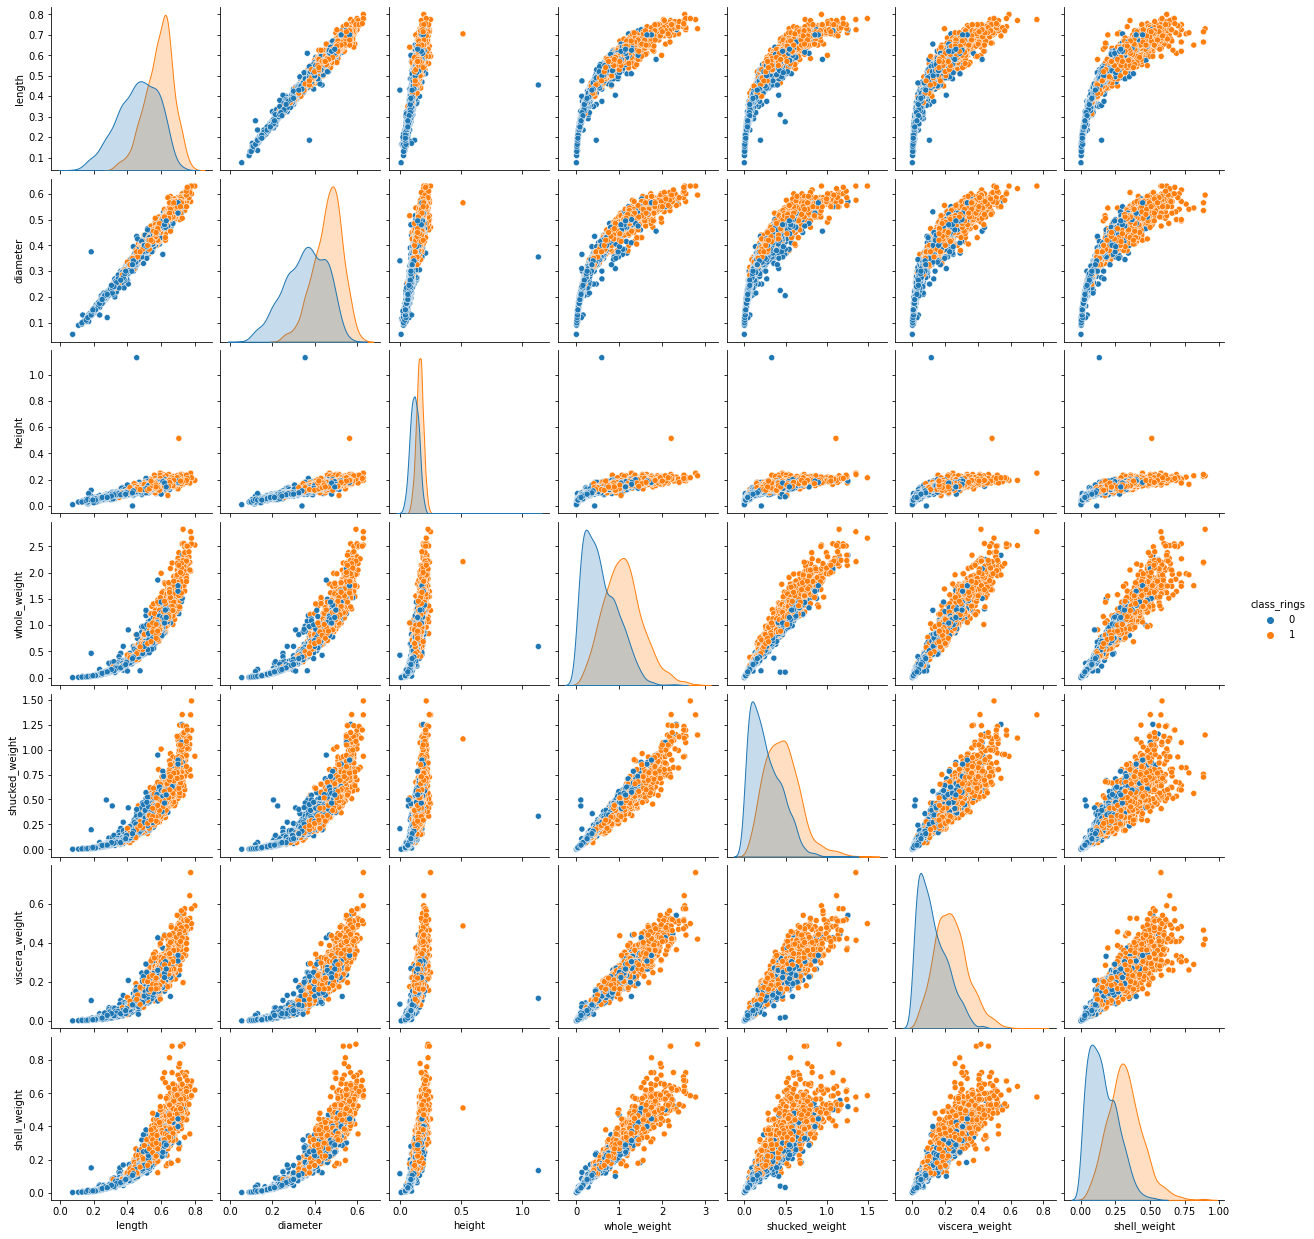

In [10]:
# verificando o comportamento do dados
sns.pairplot( data = dados, hue = 'class_rings');

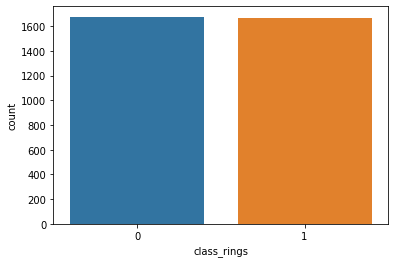

In [11]:
# verificando se os dados estão balenceados
sns.countplot (x = 'class_rings', data = dados);

**Verificando a distribuição dos dados**

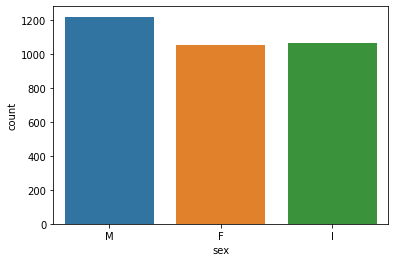

In [12]:
sns.countplot (x = 'sex', data = X_train);

In [13]:
features = X_train.drop(['sex'], axis=1)
for i in features :
    histograma = px.histogram (dados, x =i, marginal = 'box', nbins = 30)  
    histograma.update_layout(title= ("Histograma simples: " + i).replace('_', ' '))
    histograma.show()
    
    boxplot = px.box(dados, x ='class_rings', y =i, color = 'class_rings')
    boxplot.update_layout(title= ("Boxplot por classe: " + i).replace('_', ' '))
    boxplot.show()
    

É possivel verificar a presença de outlies no dados. Porém, aqui podemos ter duas situações :
- os outlier serem mensurações erroneas
- os outlier serem na verdade mensurações corretas que representam conchas com greometria (forma e dimensão) diferentes. Nesse caso a retirada dos outliers poderia prejudicar o meu modelo.

Outro ponto de atenção é com relação as distribuições dos dados. Podemos verificar que as features não possui uma distribuição assimétrica dos dados, a maioria possui uma inclinação positiva.


Para conhecer o quão os dados estão assimétricos podemos utilizar a funação skew()

In [14]:
# verificando a assimetria dos dados
dados.skew().sort_values(ascending = False)

height            3.646428
shucked_weight    0.736319
viscera_weight    0.592769
shell_weight      0.580712
whole_weight      0.531960
class_rings       0.007189
diameter         -0.629523
length           -0.658420
dtype: float64

Nota-se que a feature height possuei uma alta assimetria à direita.
Isso pode estar indicando uma grande quantidade de outliers nessa variável. Já nas demais a cauda não é tão pronunciada.

Outro teste que vale a pena ser realizado antes de decidir se retiro ou não outliers, é verificar a correlação dos dados

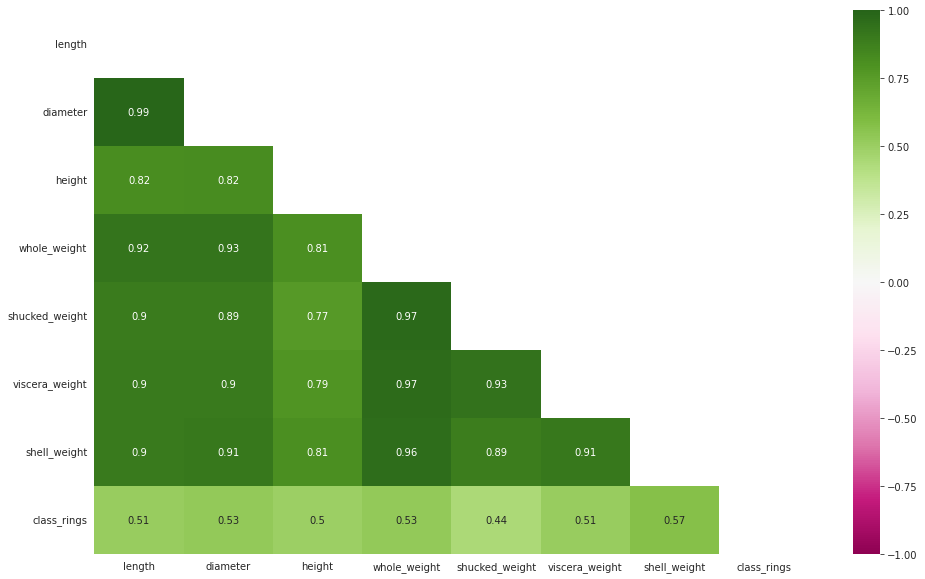

In [15]:
# verificando a correlação de pearson entre as variáveis

# 1- gerando a correlação de Perason para vinho branco
correlacao_pearson = dados.corr()

#2- Gerando mapa heatmap
mask = np.zeros_like(correlacao_pearson)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16,10))
    ax = sns.heatmap(correlacao_pearson, mask=mask, annot=True, vmin=-1, vmax=1,cmap="PiYG")

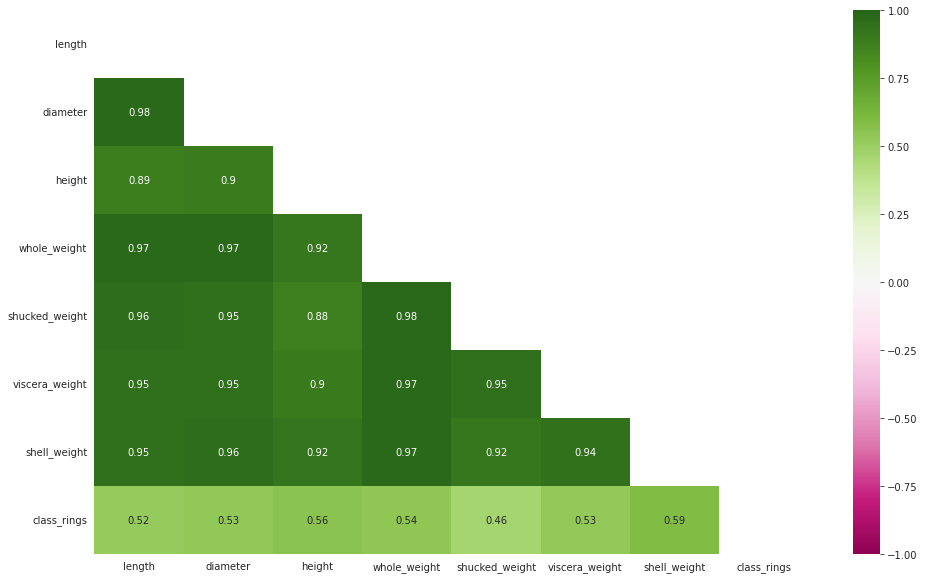

In [16]:
# verificando a correlação de spearman entre as variáveis

# 1- gerando a correlação de Perason para vinho branco
correlacao_spearman = dados.corr(method='spearman')

#2- Gerando mapa heatmap
mask = np.zeros_like(correlacao_spearman)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(16,10))
    ax = sns.heatmap(correlacao_spearman, mask=mask, annot=True, vmin=-1, vmax=1,cmap="PiYG")

Nota-se uma forte correlação positiva entre quase todas as features, entretanto a correlação com a variável target é moderada.

O grande destaque é para a correlação length * diameter >= 0,97. 
E também a feature whole weight, que possui uma correlação 96-97% com 3 das 7 features.

Esse evento é chamado de multicolinearidade, ou seja, dois ou mais recursos carregando a mesma informação. 
Para alguns algorítimos como de regressão linear ( que não é o caso, nesse trabalho), as altas correlações, principalemnte as quase perfeitas e perfeitas, podem acabar prejudicando o modelo. 

Há muitas interpretações sobre a multicolinearidade, se devemos ou não retirar uma das features, visto que os algorítomos de ML são projetados para serem "robustos diante de preditores correlacionados".  Entretanto, muitos dicordam dessa afirmação.

Como esse trabalho é uma forma de compreender como e o que pode afetar os resultados. Para alguns algorítmos, irei fazer dois modelos(com todas as features e sem as features diameter e whole weight), para compreender como que as alta correlações citadas pode afetar os resultados.


Links:

- https://stats.stackexchange.com/questions/168622/why-is-multicollinearity-not-checked-in-modern-statistics-machine-learning
- https://datascience.stackexchange.com/questions/24452/in-supervised-learning-why-is-it-bad-to-have-correlated-features
- https://towardsdatascience.com/why-feature-correlation-matters-a-lot-847e8ba439c4

Já com relação aos outliers, pensado que nas minha análise descritiva não tive nenhum dado como peso ou dimensão igual a zero. Não irei retirar os outliers e assumir que o meu modelo conseguirá trabalhar com conchas que estão "fora do padrão". Como por exemplo as com comprimento elevado. Pois ao comparar os valores de média  e mediana, não se observar uma grande diferença entre os resultados.  

# Modelagem

Transformando os dados da coluna sex para: 0, 1 ou 2

In [17]:
X_train = pd.get_dummies(X_train, columns = ['sex'], drop_first=True)

In [18]:
X_train

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,sex_I,sex_M
2616,0.670,0.520,0.190,1.6385,0.8115,0.3690,0.3910,0,1
231,0.625,0.505,0.215,1.4455,0.4960,0.2870,0.4350,0,1
1148,0.580,0.450,0.155,0.9300,0.3850,0.2460,0.2650,0,0
1719,0.650,0.510,0.160,1.3835,0.6385,0.2905,0.3665,0,1
3099,0.580,0.430,0.125,0.9115,0.4460,0.2075,0.1210,0,1
...,...,...,...,...,...,...,...,...,...
1686,0.620,0.480,0.175,1.0405,0.4640,0.2225,0.3000,0,0
4082,0.570,0.445,0.160,1.0145,0.5160,0.1640,0.3000,0,1
1327,0.570,0.450,0.145,0.7510,0.2825,0.2195,0.2215,1,0
2609,0.630,0.495,0.145,1.1470,0.5455,0.2660,0.2885,0,0


In [19]:
# retirando as colunas com alta correlação
X_train_pc = X_train.drop(columns=['diameter', 'whole_weight'], axis=1)
X_train_pc.head(3)

,length,height,shucked_weight,viscera_weight,shell_weight,sex_I,sex_M
2616,0.670,0.190,0.8115,0.369,0.391,0,1
231,0.625,0.215,0.4960,0.287,0.435,0,1
1148,0.580,0.155,0.3850,0.246,0.265,0,0


In [20]:
# Criando um dicionário com as métricas a serem utilizadas 
custom_scorer = {'accuracy': make_scorer(accuracy_score),
                 'precision': make_scorer(precision_score, average='macro'),
                 'recall': make_scorer(recall_score, average='macro'),
                 'f1': make_scorer(f1_score, average='macro'),
                 'rocAUC': make_scorer(roc_auc_score, average='macro')
                 }

# Criando uma função para calcular e imprimir as métricas escolhidas
def imprime_resultados(resultS):

    # dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_precision', 'test_recall', 'test_f1', 'test_rocAUC'])
    acc_mean = resultS['test_accuracy'].mean()
    acc_std= resultS['test_accuracy'].std()

    print ("Acurácia: ", acc_mean.round(4))
    print("Intervalo da acurácia: [%.2f, %.2f]" % ((acc_mean - 2 * acc_std)*100, (acc_mean + 2 * acc_std) * 100))

    print (" ")

    print ("Precision: ", resultS['test_precision'].mean().round(4))
    print ("Recall: ", resultS['test_recall'].mean().round(4))
    print ("F1 Score: ", resultS['test_f1'].mean().round(4))
    print ("AUROC: ", resultS['test_rocAUC'].mean().round(4))

## Árvore de Decisão

De acordo com as pessoas que trabalhan na área, o algorítimo de árvore de decisão não é afetado pela multicolinearidade, sendo assim tralharei com todas as features nesse modelo.

In [21]:
# definindo o algoritimo 

model_DT= DecisionTreeClassifier(max_depth=6, random_state=SEED)

# usando o StratifiedKFold como forma de separar o CV
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

results1 = cross_validate (model_DT, X_train, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results1)


Acurácia:  0.7799
Intervalo da acurácia: [72.60, 83.38]
 
Precision:  0.7806
Recall:  0.78
F1 Score:  0.7798
AUROC:  0.78


Usando a técnica do cross_validade, já consigo obter as metricas de avaliação, porém não sou capaz de gerar o dedeseho á árvore, sendo o erro:  "não ter feito o fit".

Então para esse modelo, também irei utilizar um loop. 
Caso os resultados sejam diferentes (o que realmente ocorreu), trabalharei com as métricas obtidas no loop para escolhero melhor modelo.

In [22]:
X_train_arr = X_train.values
y_train_arr = y_train.values

list_accuracy = []
list_precision = []
list_recall = []
list_f1_score = []
list_AUROC = []

i = 1
for train_index, val_index in cvSKfold.split(X_train, y_train):
 
    # Pegando o X e o y de treino e de validação para aquela iteração
    KFold_X_train, KFold_X_val = X_train_arr[train_index], X_train_arr[val_index]
    KFold_y_train, KFold_y_val = y_train_arr[train_index], y_train_arr[val_index]
    
    # Treinando o modelo da iteração
    model_DT.fit(KFold_X_train, KFold_y_train)
    
    # Fazendo as previsões no "fold" de validação
    y_pred = model_DT.predict(KFold_X_val)
    
    #Calcula as métricas
    acc = accuracy_score(KFold_y_val, y_pred)
    prec = precision_score(KFold_y_val, y_pred)
    recall = recall_score(KFold_y_val, y_pred)
    f1 = f1_score(KFold_y_val, y_pred)
    roc = roc_auc_score(KFold_y_val, y_pred)
    
    # Salvando as métricas na lista
    list_accuracy.append(acc)
    list_precision.append(prec)
    list_recall.append(recall)
    list_f1_score.append(f1)
    list_AUROC.append(roc)
    i += 1


acc_mean = np.mean(list_accuracy)
acc_std = np.std(list_accuracy)

print ("Acurácia: ", acc_mean.round(4))
print("Intervalo da acurácia: [%.2f, %.2f]" % ((acc_mean - 2 * acc_std)*100, (acc_mean + 2 * acc_std) * 100))
print (" ")
print ("Precision: ", np.mean(list_precision).round(4))
print ("Recall: ", np.mean(list_recall).round(4))
print ("F1 Score: ", np.mean(list_f1_score).round(4))
print ("AUROC: ", np.mean(list_AUROC).round(4))


Acurácia:  0.7799
Intervalo da acurácia: [72.60, 83.38]
 
Precision:  0.7741
Recall:  0.7897
F1 Score:  0.7815
AUROC:  0.78


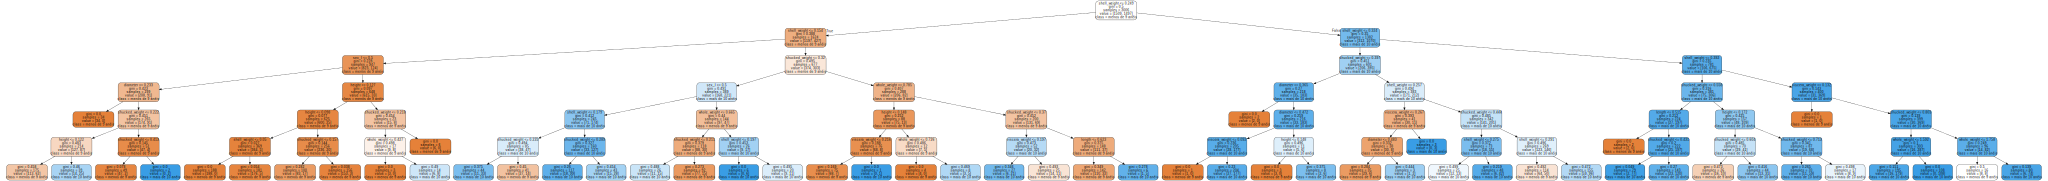

In [23]:
features = X_train.columns
dot_data = export_graphviz(model_DT, out_file=None,
                           filled = True, rounded = True,
                           feature_names = features,
                          class_names = ["menos de 9 anéis", "mais de 10 anéis"])
grafico = graphviz.Source(dot_data)
grafico

## Regressão Logística
Há algumas resalvas em relação ao algoritmo de regressão logistica ser sucetivel  as variáveis altamente correlacionadas. Nesse caso irei fazer  doi modelos, com todas as features  e com as parciais 

In [24]:
# definindo o algoritimo 
model_RL= LogisticRegression(random_state=SEED, solver='lbfgs', max_iter=1000)

# usando o StratifiedKFold como forma de separar o CV
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

**Com todas as features**

In [25]:
results2 = cross_validate (model_RL, X_train, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results2)

Acurácia:  0.7713
Intervalo da acurácia: [72.88, 81.37]
 
Precision:  0.7721
Recall:  0.7713
F1 Score:  0.7711
AUROC:  0.7713


**Com parte das features**

In [26]:
results3 = cross_validate (model_RL, X_train_pc, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results3)

Acurácia:  0.7677
Intervalo da acurácia: [72.20, 81.34]
 
Precision:  0.7693
Recall:  0.7678
F1 Score:  0.7674
AUROC:  0.7678


basicamente não houve mudanças entre as métricas

## KNN

Para o KNN será necessário fazer uma normalização dos dados.
Nesse caso irei utilizar o pipeline para já normalizar e prever os resultados.

Além disso, como algumas literaturas citam que a multicolineariadade afeta os resultados do algorítmo de KNN, irei fazer os dois modelos também.

In [27]:
# definindo o algoritimo
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# determinando as etapas 
pipe_KNN = Pipeline([('scaler', StandardScaler()),
                     ('model', KNeighborsClassifier(n_neighbors=17, n_jobs=1))])

**Com todas as features**

In [28]:
results4= cross_validate(pipe_KNN, X_train, y_train, 
                         scoring=custom_scorer, cv=cvSKfold,
                         return_train_score=False)

imprime_resultados (results4)

Acurácia:  0.7865
Intervalo da acurácia: [74.75, 82.55]
 
Precision:  0.7882
Recall:  0.7866
F1 Score:  0.7862
AUROC:  0.7866


**Com parte das features**

In [29]:
results5= cross_validate(pipe_KNN, X_train_pc, y_train, 
                         scoring=custom_scorer, cv=cvSKfold,
                         return_train_score=False)

imprime_resultados (results5)

Acurácia:  0.7874
Intervalo da acurácia: [75.34, 82.14]
 
Precision:  0.7894
Recall:  0.7875
F1 Score:  0.7871
AUROC:  0.7875


Novamente não houve grandes mudanças nos resultados

## Naive-Bayes

Segundo a literatura o algorítmo de Naive-Bayes não  é afetado pela multicolinearidade, pois assume que um recurso não está correlacionado com nenhum outro, mesmo que isso não ocorrá com frequencia na vida real. 

https://www.quora.com/Does-multicollinearity-affect-naive-Bayes-If-yes-no-then-why

In [30]:
# definindo o algoritimo 
model_NB = GaussianNB()

# usando o StratifiedKFold como forma de separar o CV
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

In [31]:
results5 = cross_validate (model_NB, X_train, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results5)

Acurácia:  0.7281
Intervalo da acurácia: [67.01, 78.62]
 
Precision:  0.7288
Recall:  0.7282
F1 Score:  0.728
AUROC:  0.7282


## Random Forest

Para o algorítmo de random forest há resalvas com relação ao fato das variáveis com alta correlação mascarar as interações. Sendo assim, tmabé irei fazer o teste com os dois modelos

In [32]:
# definindo o algoritimo 
model_RF = RandomForestClassifier(n_estimators=1000, max_depth=12, max_features="sqrt", random_state=SEED)

# usando o StratifiedKFold como forma de separar o CV
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

**Com todas as features**

In [33]:
results6 = cross_validate (model_RF, X_train, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results6)

Acurácia:  0.7937
Intervalo da acurácia: [75.02, 83.73]
 
Precision:  0.7959
Recall:  0.7938
F1 Score:  0.7934
AUROC:  0.7938


**Com parte das features**

In [34]:
results7 = cross_validate (model_RF, X_train_pc, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results7)

Acurácia:  0.7925
Intervalo da acurácia: [74.98, 83.52]
 
Precision:  0.7951
Recall:  0.7926
F1 Score:  0.7921
AUROC:  0.7926


Para o random forest, também não se nota uma grande diferença entre os valores das métricas

**SVC**

In [35]:
# definindo o algoritimo
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# determinando as etapas 
pipe_SVC = Pipeline([('scaler', StandardScaler()),
                     ('model', SVC(kernel='rbf', random_state=SEED))])

In [36]:
results8 = cross_validate (pipe_SVC, X_train_pc, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results8)

Acurácia:  0.7901
Intervalo da acurácia: [76.22, 81.80]
 
Precision:  0.7941
Recall:  0.7903
F1 Score:  0.7895
AUROC:  0.7903


In [37]:
# definindo o algoritimo
cvSKfold = StratifiedKFold(n_splits = 10, shuffle=True, random_state=SEED)

# determinando as etapas 
pipe_SVC = Pipeline([('scaler', StandardScaler()),
                     ('model', SVC(kernel='rbf', random_state=SEED))])

In [38]:
results9 = cross_validate (pipe_SVC, X_train_pc, y_train, cv = cvSKfold,
                          scoring = custom_scorer, return_train_score=False)

imprime_resultados(results9)

Acurácia:  0.7901
Intervalo da acurácia: [76.22, 81.80]
 
Precision:  0.7941
Recall:  0.7903
F1 Score:  0.7895
AUROC:  0.7903


# Testando o modelo 

Dentre todos os modelos estudados. O que se mostou ter melhores resultados foi o random forest.

Comparando as métricas entre os com todas as features e somente com uma parte delas, decidi seguir utilizando todas as features, visto que o ganho é muito pequeno. 


In [39]:
X_test = pd.get_dummies(X_test, columns = ['sex'], drop_first=True)

In [41]:
# Não consegiu fazer com o resultado da validação cruzada 
model = RandomForestClassifier(n_estimators=1000, max_depth=12, max_features="sqrt", random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       420
           1       0.77      0.83      0.80       416

    accuracy                           0.79       836
   macro avg       0.79      0.79      0.79       836
weighted avg       0.79      0.79      0.79       836



De froma geral , o modelo acerat ~ 80% das previsões

# Treinando o modelo com todos os  dados

In [42]:
X = pd.get_dummies(X, columns = ['sex'], drop_first=True)

In [43]:
# Não consegiu fazer com o resultado da validação cruzada 
model = RandomForestClassifier(n_estimators=10000, max_depth=12, max_features="sqrt", random_state=SEED)
model.fit(X, y)

RandomForestClassifier(max_depth=12, max_features='sqrt', n_estimators=10000,
                       random_state=42)